In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

stock = yf.download("AMZN", start="2019-01-01", end="2023-04-20")
crypto = yf.download("SOL-USD", start="2019-01-01", end="2023-04-20")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
def prepare_data(data):
    # Extract the 'Close' prices
    close_data = data.filter(['Close'])
    close_dataset = close_data.values

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_dataset)

    return scaled_data, scaler


In [37]:
stock_data, stock_scaler = prepare_data(stock)
crypto_data, crypto_scaler = prepare_data(crypto)


In [38]:
def create_train_test_data(scaled_data, look_back=60, train_ratio=0.8):
    # Create the training dataset
    train_data_len = int(np.ceil(len(scaled_data) * train_ratio))
    train_data = scaled_data[:train_data_len, :]
    
    x_train, y_train = [], []
    for i in range(look_back, len(train_data)):
        x_train.append(train_data[i-look_back:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Create the testing dataset
    test_data = scaled_data[train_data_len-look_back:, :]
    x_test, y_test = [], []
    for i in range(look_back, len(test_data)):
        x_test.append(test_data[i-look_back:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test


In [39]:
stock_x_train, stock_y_train, stock_x_test = create_train_test_data(stock_data)
crypto_x_train, crypto_y_train, crypto_x_test = create_train_test_data(crypto_data)


In [40]:
def build_train_lstm_model(x_train, y_train, batch_size=1, epochs=5):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    return model


In [41]:
stock_model = build_train_lstm_model(stock_x_train, stock_y_train)
crypto_model = build_train_lstm_model(crypto_x_train, crypto_y_train)


Epoch 1/5
801/801 [==============================] - 13s 14ms/step - loss: 0.0056
Epoch 2/5
801/801 [==============================] - 11s 14ms/step - loss: 0.0024
Epoch 3/5
801/801 [==============================] - 11s 14ms/step - loss: 0.0018
Epoch 4/5
801/801 [==============================] - 11s 14ms/step - loss: 0.0016
Epoch 5/5
801/801 [==============================] - 11s 13ms/step - loss: 0.0014
Epoch 1/5
817/817 [==============================] - 13s 14ms/step - loss: 0.0051
Epoch 2/5
817/817 [==============================] - 11s 14ms/step - loss: 0.0021
Epoch 3/5
817/817 [==============================] - 11s 14ms/step - loss: 0.0012
Epoch 4/5
817/817 [==============================] - 11s 14ms/step - loss: 0.0013
Epoch 5/5
817/817 [==============================] - 11s 13ms/step - loss: 9.5106e-04


In [42]:
import numpy as np

def visualize_predictions(data, scaler, model, x_train, x_test, days_to_show=None):
    # Make predictions
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Visualize the data
    train = data[:len(x_train)+60]
    valid = data[len(x_train)+60:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

    # Add trend lines
    valid_days = np.arange(len(valid))
    close_trend_coef = np.polyfit(valid_days, valid['Close'], 1)
    close_trend_line = close_trend_coef[0] * valid_days + close_trend_coef[1]

    pred_trend_coef = np.polyfit(valid_days, valid['Predictions'], 1)
    pred_trend_line = pred_trend_coef[0] * valid_days + pred_trend_coef[1]

    plt.plot(valid.index, close_trend_line, 'r--', label='Close Trend')
    plt.plot(valid.index, pred_trend_line, 'g--', label='Predictions Trend')

    if days_to_show is not None:
        latest_date = valid.index[-1]
        earliest_date = valid.index[-days_to_show]
        plt.xlim(earliest_date, latest_date)

    plt.legend()
    plt.show()



7/7 [==============================] - 1s 11ms/step


C:\Users\trent\AppData\Local\Temp\ipykernel_28204\428736618.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


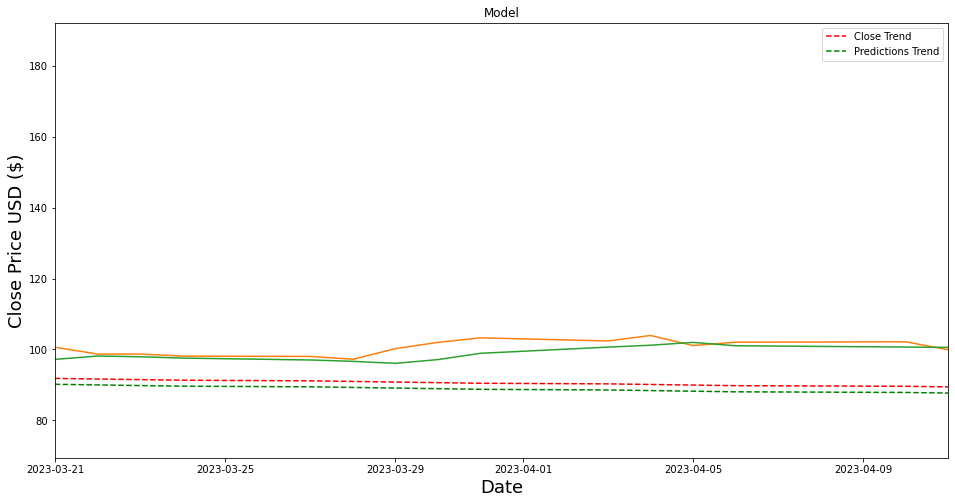

7/7 [==============================] - 1s 11ms/step


C:\Users\trent\AppData\Local\Temp\ipykernel_28204\428736618.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


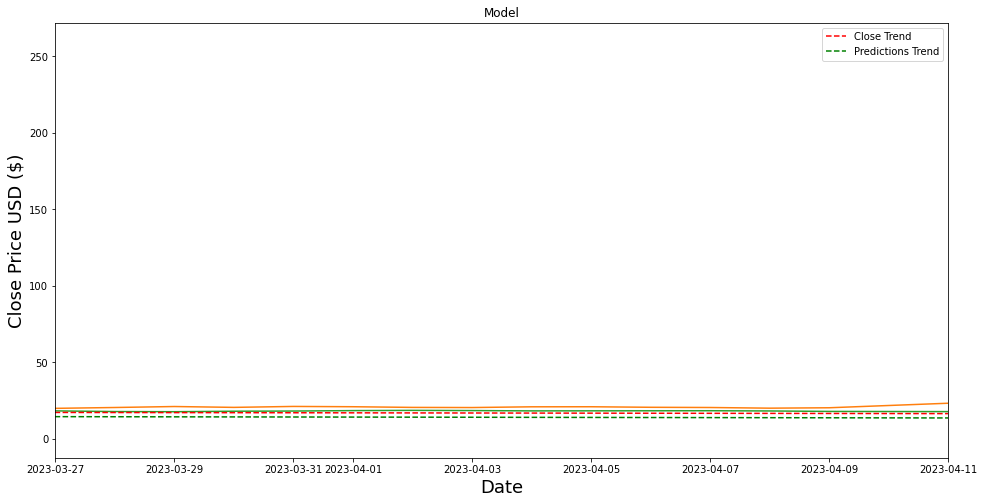

In [43]:
visualize_predictions(stock.filter(['Close']), stock_scaler, stock_model, stock_x_train, stock_x_test, days_to_show=15)
visualize_predictions(crypto.filter(['Close']), crypto_scaler, crypto_model, crypto_x_train, crypto_x_test, days_to_show=15)

